In [11]:
%matplotlib inline

In [12]:
import pandas as pd
import numpy as np
import scipy.constants
import copy

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.transforms as mtransforms
import matplotlib.gridspec as gridspec

import scipy
import scipy.stats as st
from matplotlib.lines import Line2D
from scipy.stats import norm

import random

from scipy.stats import shapiro



In [17]:
'''READ THERMO DATA FROM LOG.LAMMPS'''

# Read specific columns from data file:
cols = {
    0: "Step",  
    1: "Temp",  
    2: "E_pair",  
    3: "E_mol",  
    4: "TotEng",  
    5: "Press"
}
data=pd.read_fwf('modified/log.lammps', skiprows=229, skipfooter=31, usecols=cols.keys(), names=cols.values(), engine='python', dtype=float)


# Convert to dictionary of numpy arrays:
data = data.to_dict("series")
for key in data:
    data[key] = np.array(data[key].values)
    
thermo_data = data
print(thermo_data)

{'Step': array([10000., 15000., 20000., ...,     0.,  5000., 10000.]), 'Temp': array([141.98708, 300.74389, 296.74201, ..., 296.95647, 302.93264,
       304.01238]), 'E_pair': array([ -945.44873, -1181.1935 , -1432.7289 , ..., -5911.4421 ,
       -5923.5066 , -5903.4505 ]), 'E_mol': array([ 636.40922, 1262.9819 , 1271.8135 , ..., 1168.0723 , 1160.8405 ,
       1182.2301 ]), 'TotEng': array([  960.67007,  2771.1696 ,  2492.6794 , ..., -2087.8573 ,
       -2053.7122 , -2002.6109 ]), 'Press': array([ -1.28634  ,  16.769213 ,  -1.1497648, ...,  26.610076 ,
        49.924954 , -44.727237 ])}


In [22]:
'''READ COORDINATION NUMBER DATA FROM COORDS.DMP'''

# Read specific columns from data file:
cols = {
    0: "c_coords",  
}
toskip = []
for idx in range(10010):
    if (idx % 10) != 0:
        toskip.append(idx)
toskip = [i-1 for i in toskip]
#print(toskip)
# Pulls in the coords.dump file, coordination number
data=pd.read_csv('modified/coords.dmp', sep = " ", skiprows=toskip, usecols=cols.keys(), names=cols.values(), engine='python')


# Read specific columns from data file:
cols = {
    0: "TIMESTEP",  
}
toskip = []
for idx in range(10010):
    if (idx % 10) != 2:
        toskip.append(idx)
toskip = [i-1 for i in toskip]
toskip = toskip[1:]
#print(toskip)
# Pulls in the coords.dump file, timestep
data2=pd.read_csv('modified/coords.dmp', sep = " ", skiprows=toskip, usecols=cols.keys(), names=cols.values(), engine='python')



# Convert to dictionary of numpy arrays:
data = data.to_dict("series")
data2 = data2.to_dict("series")
for key in data:
    data[key] = np.array(data[key].values)
for key in data2:
    data2[key] = np.array(data2[key].values)

data2["TIMESTEP"] = np.delete(data2["TIMESTEP"], -1) # weird bug, hacky fix
data["timestep"] = data2["TIMESTEP"]

coords_data = data
print(coords_data)

{'c_coords': array([ 50,  73,  90, ..., 390, 390, 390]), 'timestep': array([  10000,   15000,   20000, ..., 5000000, 5005000, 5010000])}


In [23]:
# Really weird bug with timestep for log.lammps, so

timestep = coords_data["timestep"]

thermo_data["Step"] = None

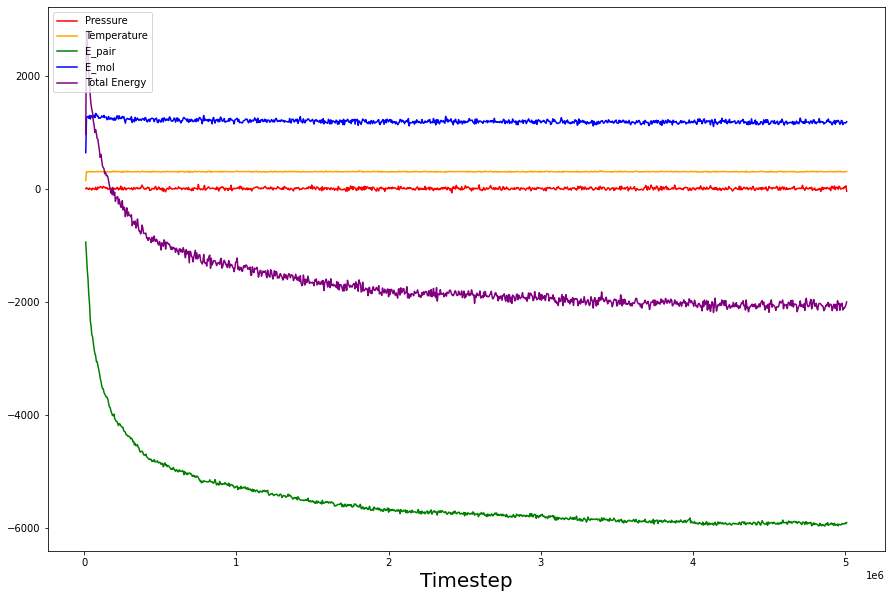

In [28]:
'''PLOT THERMO DATA'''

fig, ax = plt.subplots(figsize=[15, 10])
ax.plot(timestep, thermo_data["Press"], label="Pressure", color="red", linestyle="solid")
ax.plot(timestep, thermo_data["Temp"], label="Temperature", color="orange", linestyle="solid")
ax.plot(timestep, thermo_data["E_pair"], label="E_pair", color="green", linestyle="solid")
ax.plot(timestep, thermo_data["E_mol"], label="E_mol", color="blue", linestyle="solid")
ax.plot(timestep, thermo_data["TotEng"], label="Total Energy", color="purple", linestyle="solid")


#ax.fill_between(x1, [30 + upper_range] * len(x1), [30 + lower_range] * len(x1), color="purple", alpha=0.5, label="\'Good\' range")
ax.set_xlabel("Timestep", fontsize=20)
#ax.set_ylabel("", fontsize=20)
#ax.set_ylim(0, 52)
#ax.tick_params(axis='x', labelsize=14)
#ax.tick_params(axis='y', labelsize=14)

plt.legend(loc="upper left")
plt.savefig("figures/figure1.png", bbox_inches="tight")
plt.show()

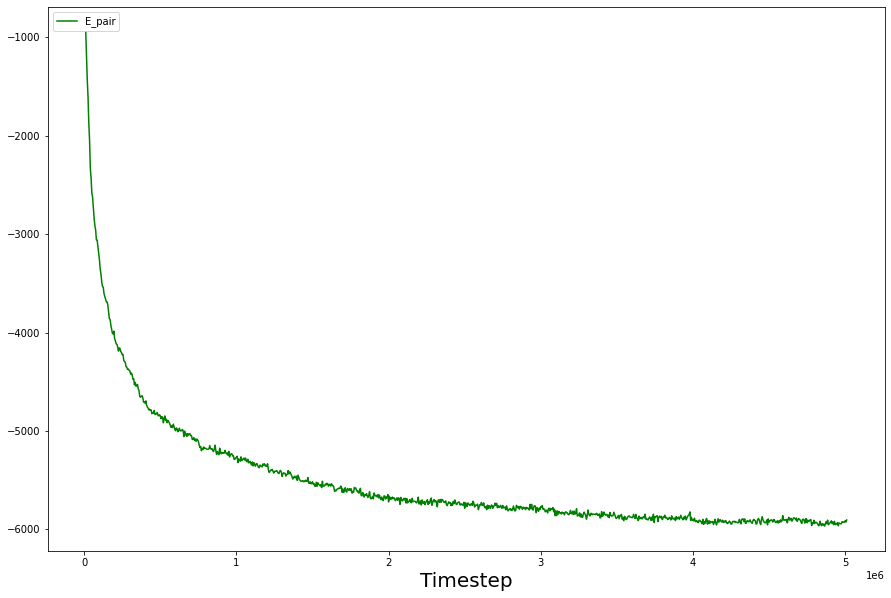

In [25]:
'''PLOT E_PAIR'''

fig, ax = plt.subplots(figsize=[15, 10])
ax.plot(timestep, thermo_data["E_pair"], label="E_pair", color="green", linestyle="solid")


#ax.fill_between(x1, [30 + upper_range] * len(x1), [30 + lower_range] * len(x1), color="purple", alpha=0.5, label="\'Good\' range")
ax.set_xlabel("Timestep", fontsize=20)
#ax.set_ylabel("", fontsize=20)
#ax.set_ylim(0, 52)
#ax.tick_params(axis='x', labelsize=14)
#ax.tick_params(axis='y', labelsize=14)

plt.legend(loc="upper left")
plt.savefig("figures/figure1.png", bbox_inches="tight")
plt.show()

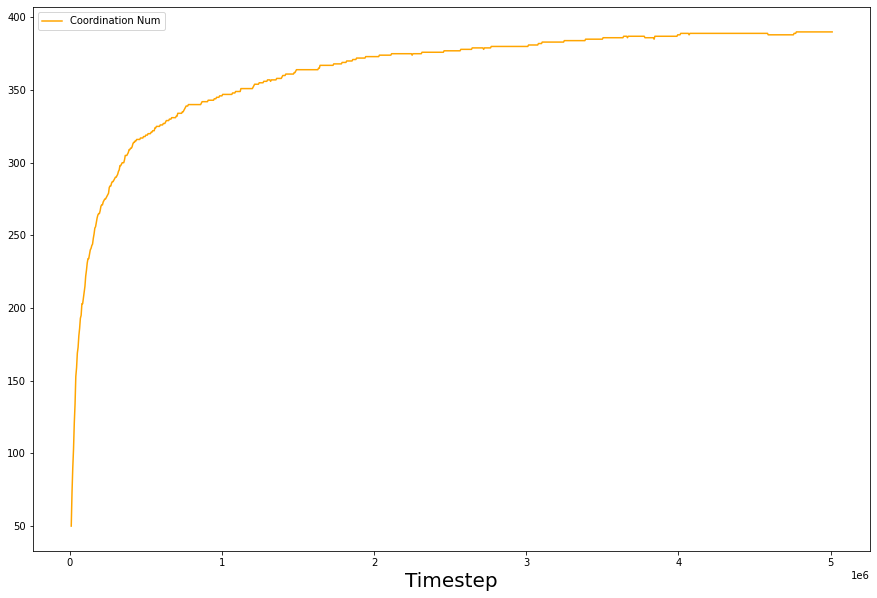

In [26]:
'''PLOT COORDINATION NUMBER'''

fig, ax = plt.subplots(figsize=[15, 10])
ax.plot(coords_data["timestep"], coords_data["c_coords"], label="Coordination Num", color="orange", linestyle="solid")


#ax.fill_between(x1, [30 + upper_range] * len(x1), [30 + lower_range] * len(x1), color="purple", alpha=0.5, label="\'Good\' range")
ax.set_xlabel("Timestep", fontsize=20)
#ax.set_ylabel("", fontsize=20)
#ax.set_ylim(0, 52)
#ax.tick_params(axis='x', labelsize=14)
#ax.tick_params(axis='y', labelsize=14)

plt.legend(loc="upper left")
plt.savefig("figures/figure1.png", bbox_inches="tight")
plt.show()

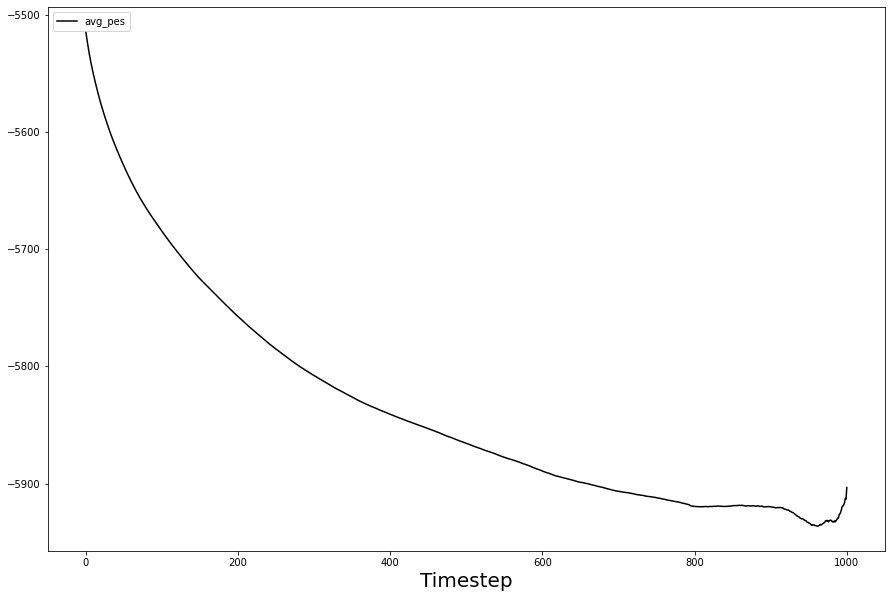

In [27]:
'''DETERMINING SECOND EQUILLIBRIUM POINT'''


pe = thermo_data["E_pair"]
pe_steps = [i for i in range(len(pe))]

avg_pes = []
for step in pe_steps:
    #print(pe_steps[:step])
    pe_eq = np.delete(pe, pe_steps[:step])
    avg_pe = np.average(pe_eq)
    avg_pes.append(avg_pe)

    

fig, ax = plt.subplots(figsize=[15, 10])
ax.plot(pe_steps, avg_pes, label="avg_pes", color="black", linestyle="solid")


#ax.fill_between(x1, [30 + upper_range] * len(x1), [30 + lower_range] * len(x1), color="purple", alpha=0.5, label="\'Good\' range")
ax.set_xlabel("Timestep", fontsize=20)
#ax.set_ylabel("", fontsize=20)
#ax.set_ylim(0, 52)
#ax.tick_params(axis='x', labelsize=14)
#ax.tick_params(axis='y', labelsize=14)

plt.legend(loc="upper left")
plt.savefig("figures/figure1.png", bbox_inches="tight")
plt.show()

